In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
pip install pydataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 61.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939414 sha256=94ff3be5f34acbfa94106ed5e76bd1098ec1de7fa30916ca43f713f669879188
  Stored in directory: /root/.cache/pip/wheels/2b/83/5c/073c3755e8b7704e4677557b2055e61026c1a2342149214c13
Successfully built pydataset


In [5]:
# imports

import pandas as pd
import numpy as np
from pydataset import data
from sklearn import datasets

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

import re
import datetime as dt

initiated datasets repo at: /root/.pydataset/


In [13]:
# read csv -> pandas.DataFrame
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/alimconfiance.csv', sep=';')

# drop unused columns
columns_to_drop = ['SIRET',
                   'Adresse_2_UA',
                   'Numero_inspection',
                   'APP_Libelle_etablissement',
                   'Libelle_commune',
                   'geores',
                   'Agrement',
                  #  'ods_type_activite',
                   'filtre']

df = df.drop(columns=columns_to_drop)

# rename used columns
df = df.rename(columns={'Synthese_eval_sanit': 'evalSanit',
                        'Code_postal': 'codePostal',
                        'Date_inspection': 'dateInspection',
                        'APP_Libelle_activite_etablissement': 'libelleActivite',
                        'ods_type_activite': 'typeActivite'})

# value to explain column set to numeric from categorical
df = df.replace({'evalSanit': {'Très satisfaisant': '4',
                               'Satisfaisant': '3',
                               'A améliorer': '2',
                               'A corriger de manière urgente': '1'}})

# type changes
df.evalSanit = df.evalSanit.astype(int)
df.codePostal = df.codePostal.astype(str)
df = df[pd.to_numeric(df['codePostal'], errors='coerce').notnull()]
df.codePostal = df.codePostal.astype(int)

df['dateInspection'] = pd.to_datetime(df['dateInspection'])
df['dateInspection'] = df['dateInspection'].map(dt.datetime.toordinal)



In [14]:
# handling the categorical column for linear regression

abattage = ['Abattage de produits de l''aquaculture',
            'Chaîne d''abattage de volaille/lagomorphe/petit gibier',
            'Chaîne d''abattage d''animaux boucherie/Gibier ongulé élevage',
            'Salle d''abattage à la ferme',
            'Traitement du gibier sauvage']

boucherieDecoupe = ['Boucherie-Charcuterie',
                     'Découpe de gibier sauvage',
                     'Découpe de gros gibier d''élevage',
                     'Découpe de produits de charcuterie',
                     'Découpe de viande de boucherie',
                     'Découpe de viandes de volailles/lagomorphe']

boulangeriePatisserie = ['Boulangerie-Pâtisserie',
                      'Chocolatier']

fromagerie = ['Caves d''affinage',
            'Déshydratation de lait ou produits laitiers',
            'Découpe de fromages',
            'Fromagerie']

collecte = ['Collecte de gibier sauvage',
            'Collecte de lait',
            'Collecte et transformation de miel',
            'Collecteur d''oeufs',
            'Pêche de production primaire']

elevage = ['Elevage de bovins',
           'Elevage de caprins',
           'Vivier produits de la pêche']

entrepot = ['Entreposage de distribution de denrées alimentaires',
            'Entreposage de produits de la pêche',
            'Entreposage de produits laitiers',
            'Entreposage de viande de boucherie',
            'Entreposage de viande de volailles',
            'Entreposage non spécialisé de denrées alimentaires']

production = ['Producteur fermier',
               'Production d''abats',
               'Production d''œuf liquide d''ovoproduit et produits à base œuf',
               'Production de collagène',
               ' de gélatine ou de PHR',
               'Production de produits à base d''escargots',
               'Production de produits à base de grenouilles']

transformation = ['Transformation de lait ou produits laitiers',
                   'Transformation de produits carnés',
                   'Transformation de produits de la pêche',
                   'VSM',
                   'VH',
                   ' préparation viandes boucherie',
                   ' préparation viandes volailles lagomorphes',
                   'Préparation de produits composés',
                   'Mareyage et préparation de produits de la pêche',
                   'Plateforme d''éclatement de produits de la pêche',
                   'Purification/Expédition de coquillages',
                   'Centre d''emballage des oeufs',
                   'Métier de bouche']

restauration = ['Gestion administrative-Restauration collective',
                'Responsable de restauration collective',
                'Restauration collective',
                'Restaurant',
                'Traiteur']

vente = ['Primeur', 'Vente en gros de viande de boucherie', 'Vente en gros de viande de volailles',
                    'Halle à M./1ére vente/Vente en gros produits de la pêche', 'Infrastructure de Marché',
                    'Rayon boucherie-charcuterie', 'Rayon fromagerie', 'Rayon fruits & légumes',
                    'Rayon pain-viennoiserie-pâtisserie', 'Rayon pain/viennoiserie/pâtisserie',
                    'Rayon poissonnerie', 'Rayon traiteur', 'Alimentation générale', 'Commerce alimentaire',
                    'Poissonnerie', 'Glacier']

distributionTransport = ['Distribution automatique',
                        'Libre service',
                        'Transport de denrées alimentaires',
                        'Autres activités de remise directe']

columns_to_initialize = ['abattage',
                         'boucherieDecoupe',
                         'boulangeriePatisserie',
                         'fromagerie',
                         'collecte',
                         'elevage',
                         'entrepot',
                         'production',
                         'transformation',
                         'restauration',
                         'vente',
                         'distributionTransport']

for column in columns_to_initialize:
    df[column] = [0] * len(df)

# df : dataframe avec les nouvelles colonnes
# listeColumn: [Abattage, DistributionTransport, BoucherieDecoupe ...]
def trieLibelleActivite(df, listColumn):
  for index in df.index:
    valueDf = df['libelleActivite'][index]
    for x in listColumn:
      # on récupère la variable associé au string x
      for y in eval(x):
        # y vaut alors un string a chercher dans le df
        if y in valueDf:
          df[x][index] = 1

trieLibelleActivite(df,columns_to_initialize)

# drop libelle

df.head()

<ipython-input-14-5b39dc3bb55b>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x][index] = 1


,codePostal,dateInspection,libelleActivite,evalSanit,typeActivite,abattage,boucherieDecoupe,boulangeriePatisserie,fromagerie,collecte,elevage,entrepot,production,transformation,restauration,vente,distributionTransport
0,80220,738635,Restaurant,3,Autres,0,0,0,0,0,0,0,0,0,1,0,0
1,74260,738574,Restaurant,3,Autres,0,0,0,0,0,0,0,0,0,1,0,0
2,92800,738432,Alimentation générale,3,Autres,0,0,0,0,0,0,0,0,0,0,1,0
3,14460,738630,Rayon boucherie-charcuterie,4,Autres,0,0,0,0,0,0,0,0,0,0,1,0
4,92210,738587,Alimentation générale,2,Autres,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# # function to get unique values
# def unique(unique_values,new_values):
#     # loop on elements
#     for x in new_values:
#         # check if exists in unique_list or not
#         if x not in unique_values and x != '_':
#             unique_values.append(x)

# unique_values = []

# # hydrate unique_valueswith df libelleActivite column
# for index in df.index:
#     strvalue = df['libelleActivite'][index]
#     new_values = re.split(r'[,]', strvalue)
#     unique(unique_values, new_values)

# df.head(20)

In [15]:
len_df = len(df)
Y = df.evalSanit
variables_explicatives = ['codePostal','dateInspection','libelleActivite','typeActivite']
X = df.loc[:,variables_explicatives]
X.insert(loc = 0, column = 'intercept', value = np.ones(len_df))

In [20]:
string = ' + '.join(columns_to_initialize)
reg = smf.ols('evalSanit ~ C(typeActivite) + codePostal + dateInspection + ' + string, data = df)
res = reg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              evalSanit   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     88.02
Date:                Tue, 12 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:40:48   Log-Likelihood:                -29075.
No. Observations:               32695   AIC:                         5.819e+04
Df Residuals:                   32674   BIC:                         5.837e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             215.9368     24.181      8.930      0.000     168.541     263.333
C(typeActivite)[T.Autres]                                              -0.0150      0.027     -0.554      0.579      -0.068       0.038
C(typeActivite)[T.Lait et produits laitiers]                            0.2531      0.030      8.369      0.000       0.194       0.312
C(typeActivite)[T.Produits de la mer et d'eau douce]                    0.1666      0.032      5.266      0.000       0.105       0.229
C(typeActivite)[T.Transport et entreposage de denrées alimentaires]     0.2360      0.047      5.054      0.000       0.144       0.328
C(typeActivite)[T.Viandes et produits carnés]                           0.0918      0.029      3.193      0.001       0.035       0.148
C(typeActivite)[T.Œufs et ovoproduits]                                  0.2341      0.035      6.720      0.000       0.166       0.302
codePostal                                                          -8.103e-07   1.23e-07     -6.580      0.000   -1.05e-06   -5.69e-07
dateInspection                                                         -0.0003   3.27e-05     -8.790      0.000      -0.000      -0.000
abattage                                                               -0.1713      0.133     -1.289      0.197      -0.432       0.089
boucherieDecoupe                                                       -0.1076      0.020     -5.322      0.000      -0.147      -0.068
boulangeriePatisserie                                                  -0.1733      0.030     -5.814      0.000      -0.232      -0.115
fromagerie                                                              0.1095      0.039      2.823      0.005       0.033       0.186
collecte                                                                0.2787      0.070      3.985      0.000       0.142       0.416
elevage                                                                 0.0960      0.075      1.287      0.198      -0.050       0.242
entrepot                                                                0.0485      0.050      0.972      0.331      -0.049       0.146
production                                                              0.1570      0.026      6.138      0.000       0.107       0.207
transformation                                                          0.0025      0.023      0.110      0.912      -0.042       0.047
restauration                                                           -0.0827      0.021     -4.031      0.000      -0.123      -0.043
vente                                                                   0.0374      0.022  

<ipython-input-21-248971009703>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


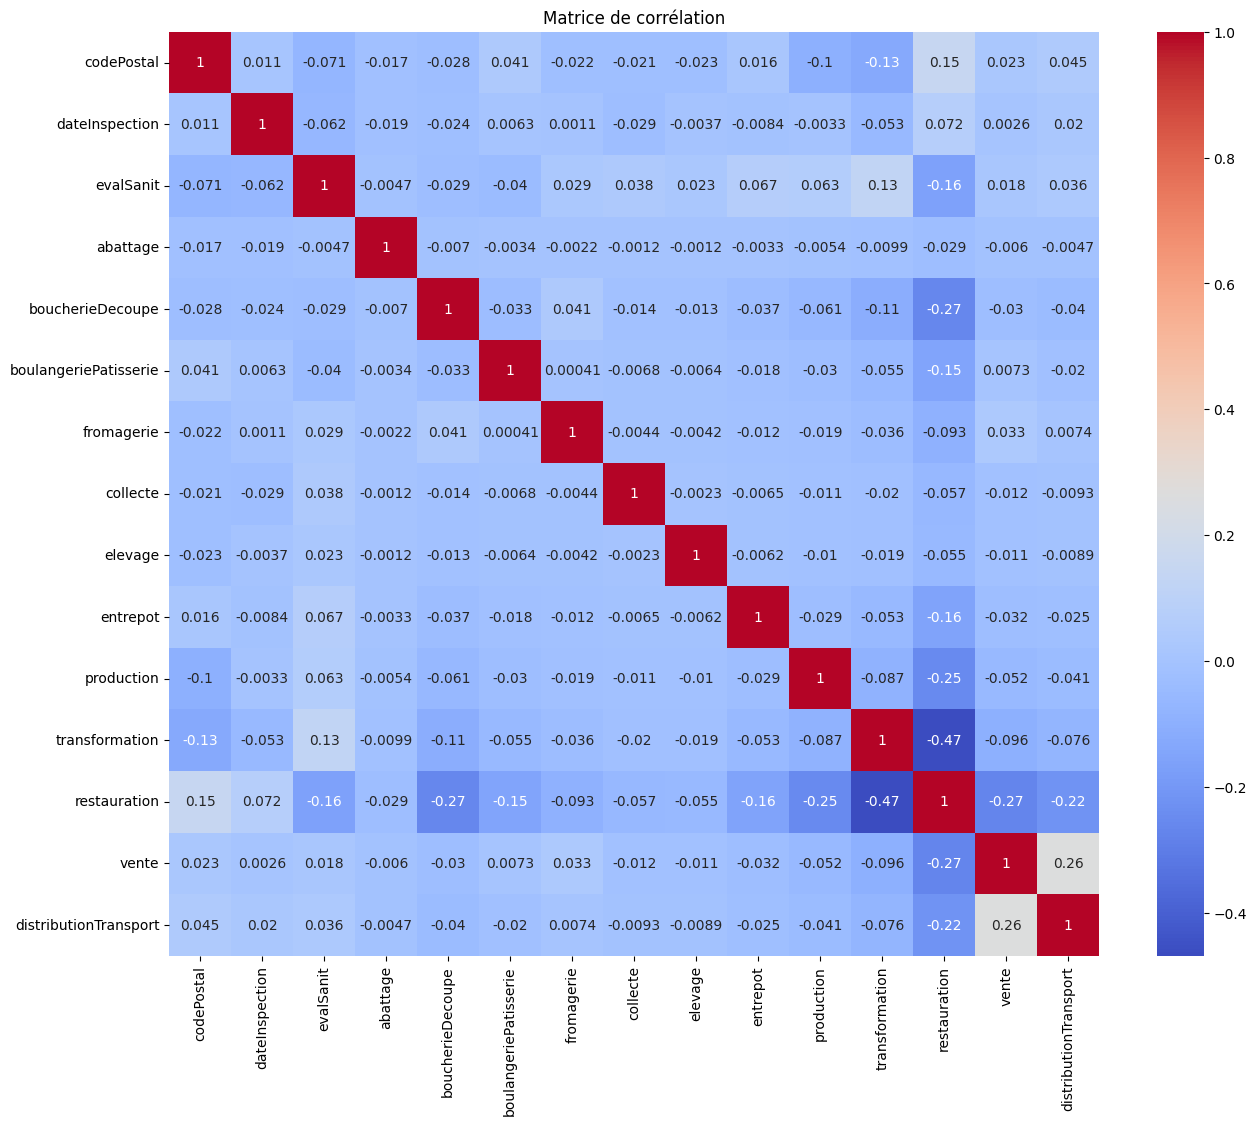

       codePostal  dateInspection  \
0           80220          738635   
1           74260          738574   
2           92800          738432   
3           14460          738630   
4           92210          738587   
...           ...             ...   
32715       97424          738609   
32716       75009          738483   
32717        4160          738627   
32718       69007          738687   
32719       97424          738609   

                                             libelleActivite  evalSanit  \
0                                                 Restaurant          3   
1                                                 Restaurant          3   
2                                      Alimentation générale          3   
3                                Rayon boucherie-charcuterie          4   
4                                      Alimentation générale          2   
...                                                      ...        ...   
32715  Chaîne d'abattage de vo

In [21]:
#creer une matrice de corrélation sur le dataframe
corr_matrix = df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()
print(df)